In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [38]:
def sigmoid(x):
  return 1/(1 + np.exp(-min(x, 37)))

def sigmoid_derivative(x):
  s_x = sigmoid(x)
  return s_x * (1.0 - s_x)

#relu
def relu(x):
  return x if x > 0 else .01 * x

def relu_derivative(x):
  return 1.0 if x > 0 else .01

In [39]:
class Neuron:

  def __init__(self, number_of_weights):
    self.parameters = np.random.uniform(-.3, .3, (number_of_weights+1, ))
    self.gradients = np.zeros((number_of_weights+1, ))
    self.previous_gradients = np.zeros((number_of_weights+1, ))
    self.mults = np.zeros((number_of_weights+1, ))
    self.size = number_of_weights + 1

  def feed_forward(self, input):
    self.mults = np.copy(input)
    dot_p = np.dot(self.parameters, input)
    return dot_p

  def gradient(self, neuron_gradient):
    self.gradients = np.add(self.gradients, self.mults * neuron_gradient)
    return self.parameters * neuron_gradient

  def zero_gradient(self):
    self.gradients = np.zeros((self.size, ))

  def back_propigate(self, a, g):
    dt = self.gradients * -a
    self.parameters += dt + g * self.previous_gradients
    self.previous_gradients = dt


  def __repr__(self):
    return f"Neuron {self.parameters}"

In [40]:
class Layer:

  def __init__(self, weights_per_neuron, number_of_neurons):
    self.layer = np.array([Neuron(weights_per_neuron) for _ in range(number_of_neurons)])
    self.activation_gradients = np.zeros((number_of_neurons + 1, ))
    self.size = number_of_neurons

  def feed_forward(self, input):
    x_values = np.append(input, 1.0)
    activations = np.zeros((self.size, ))
    for i in range(self.size):
      neuron_output = self.layer[i].feed_forward(x_values)
      #activations[i] = sigmoid(neuron_output)
      activations[i] = relu(neuron_output)
      # self.activation_gradients[i] = sigmoid_derivative(neuron_output)
      self.activation_gradients[i] = relu_derivative(neuron_output)
    self.activation_gradients[self.size] = 0.0
    return activations

  def gradient(self, previous_layer_gradients):
    neuron_gradients = np.multiply(self.activation_gradients, previous_layer_gradients)
    layer_gradients = np.zeros((self.layer[0].size, ))
    for i in range(self.size):
      layer_gradients = np.add(layer_gradients, self.layer[i].gradient(neuron_gradients[i]))
    return layer_gradients

  def zero_gradient(self):
    for i in range(self.size):
      self.layer[i].zero_gradient()

  def back_propigate(self, a, g):
    for i in range(self.size):
      self.layer[i].back_propigate(a, g)

  def __repr__(self):
    s = ""
    for i in range(self.size):
      s += str(self.layer[i])+"\n"
    return s

In [41]:
class NeuralNetwork:

  def __init__(self, size):
    for i in range(0, len(size)-1, 1):
      if (size[i][1] != size[i+1][0]):
        raise Exception("Size array invalid!")

    self.network = np.array([Layer(l[0], l[1]) for l in size])
    self.size = len(size)

  def feed_forward(self, input):
    previous_layer_activations = np.copy(input)
    for i in range(self.size):
      temp = self.network[i].feed_forward(previous_layer_activations)
      previous_layer_activations = np.copy(temp)

    return previous_layer_activations[0]

  def predict(self, x_data):
    predictions = np.zeros((len(x_data), ))
    for i in range(len(x_data)):
      predictions[i] = self.feed_forward(x_data[i])
    return predictions

  def gradient(self, dE_dOutput):
    last_layer_gradients = np.array([dE_dOutput for _ in range(self.network[self.size-1].size + 1)])
    previous_gradients = self.network[self.size-1].gradient(last_layer_gradients)
    if (self.size<2):
      return

    for i in range(self.size-2, -1, -1):
      temp = self.network[i].gradient(previous_gradients)
      previous_gradients = temp

  def zero_gradient(self):
    for i in range(self.size):
      self.network[i].zero_gradient()

  def back_propigate(self, a, g):
    for i in range(self.size):
      self.network[i].back_propigate(a, g)

  def __repr__(self):
    s = ""
    for i in range(self.size):
      s += str(self.network[i])+"\n"
    return s

In [42]:
def print_graph(y_pred):
  global x_values, y_train

  # Plotting the first line
  plt.plot(x_values, y_train, label='Real')

  # Plotting the second line
  plt.plot(x_values, y_pred, label='Pred')

  # Adding labels and title
  plt.xlabel('X-axis Label')
  plt.ylabel('Y-axis Label')
  plt.title('2D Line Graph with Two Lines')

  # Adding a legend
  plt.legend()

  # Display the plot
  plt.show()

In [43]:
def epoch(a, g, start, finish):
  global X_train, y_train, NN, indicies
  NN.zero_gradient()
  y_values = list()
  predictions = list()

  for i in range(start, finish, 1):
    pred = NN.feed_forward(X_train[indicies[i]])
    predictions.append(pred)
    NN.gradient(pred - y_train[indicies[i]])
    y_values.append(y_train[indicies[i]])

  NN.back_propigate(a, g)
  loss = cost(predictions, y_values)
  return loss

In [44]:
def fit(a, g, method=""):
  global X_train, y_train, NN

  if (method=="sgd"):
    batch_size = 32
    end = int(len(X_train)/batch_size) * batch_size

    for i in range(0, end, batch_size):
      start = 0
      finish = start + batch_size
      loss = epoch(a, g, start, finish)

    loss = epoch(a, g, finish, len(X_train))
  elif (method=="full"):
    loss = epoch(a, g, 0, len(X_train))
  else:
    predictions = list()
    for i in range(len(X_train)):
      NN.zero_gradient()
      pred = NN.feed_forward(X_train[i])
      predictions.append(pred)
      NN.gradient(pred - y_train[i])
      NN.back_propigate(a, g)

    loss = cost(predictions, y_train)

  return loss

In [45]:
def cost(y_pred, y_real):
  loss = 0.0
  for i in range(len(y_pred)):
    loss += .5*(y_pred[i] - y_real[i])**2
  return loss

In [46]:
input_size = 100

In [47]:
X_train = list()
x_values = list()
y_train = list()
indicies = np.array([], dtype=int)

for i in range(501):
  num = -2.0 + i*.008
  indicies = np.append(indicies, i)
  x_values.append(num)
  X_train.append(np.array([num for _ in range(input_size)]))
  #y_train.append(1.0 * num)
  y_train.append(np.power(num, 3.0))

In [48]:
# np.random.shuffle(indicies)

In [49]:
#NN = NeuralNetwork([[input_size, 100], [100, 100], [100, 100], [100, 100], [100, 100], [100, 100]])
NN = NeuralNetwork([[input_size, 4], [4, 4]])

In [50]:
print(NN.network.shape, NN.network[0].size, NN.network[0].layer[0].size)

(2,) 4 101


In [51]:
# start = time.time()
# for i in range(10000):
#   NN.feed_forward(np.zeros((100, )))
# finish = time.time()
# print(f"time for 10000 iterations = {finish - start}")

In [52]:
#print(NN)

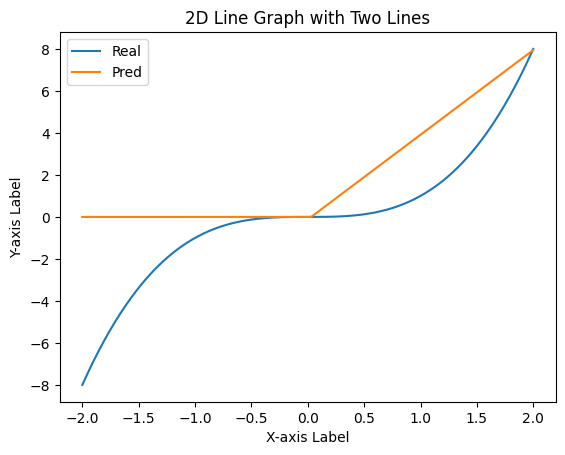

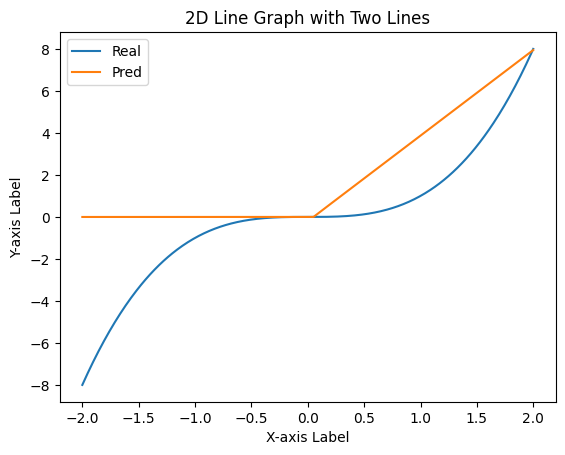

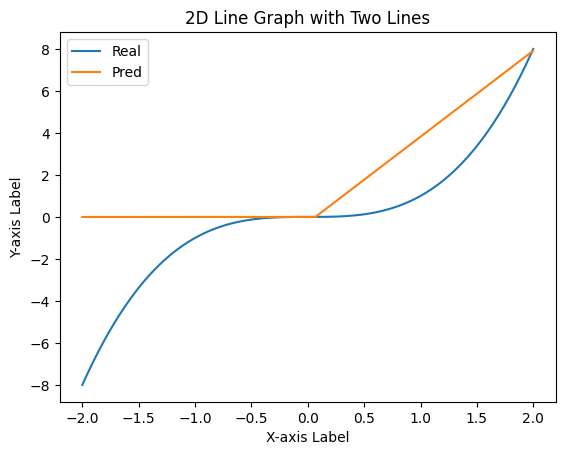

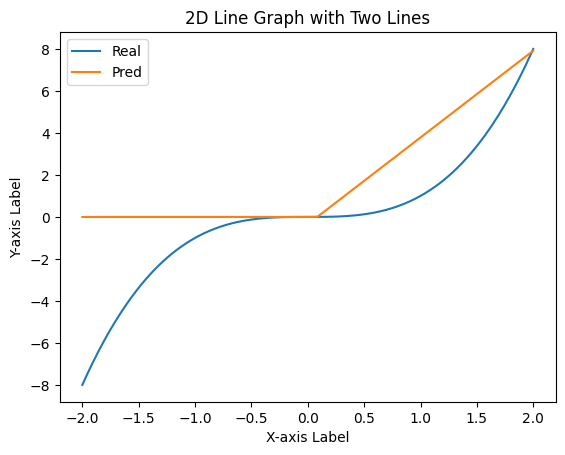

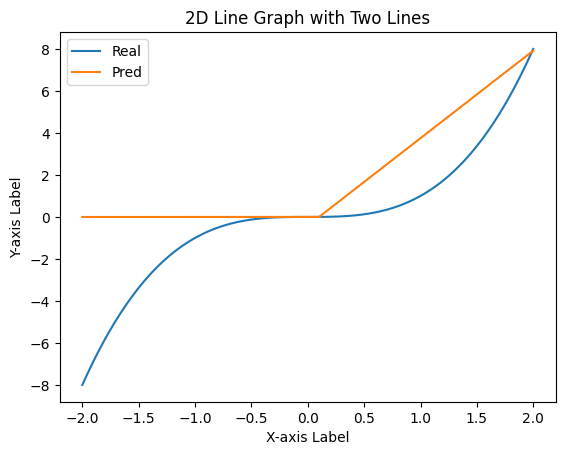

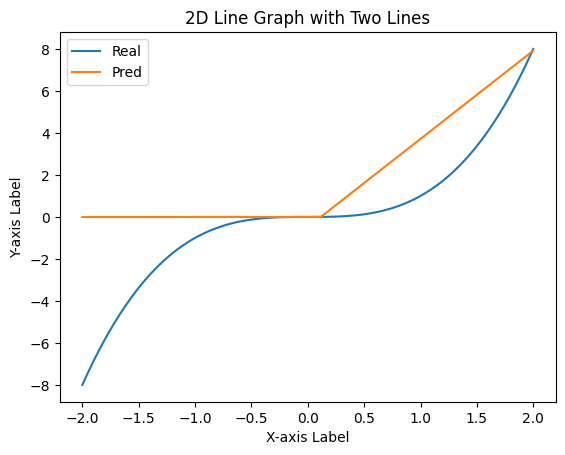

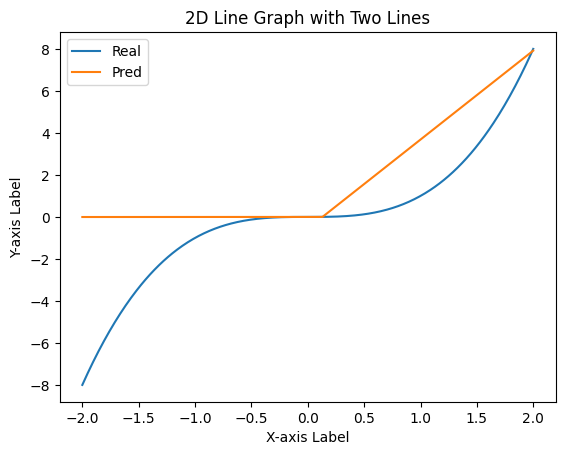

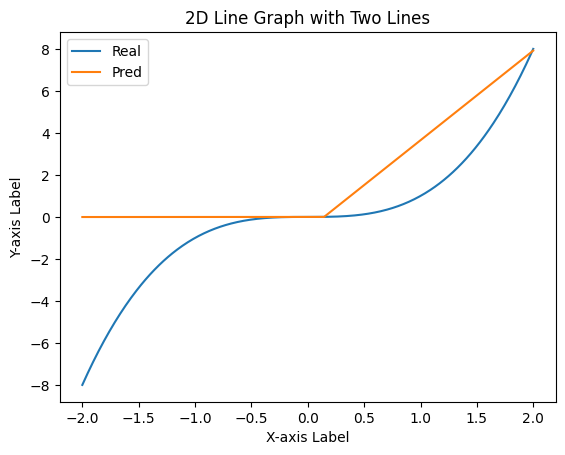

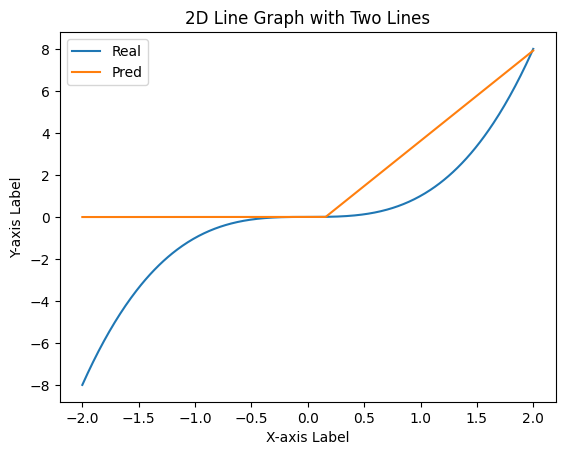

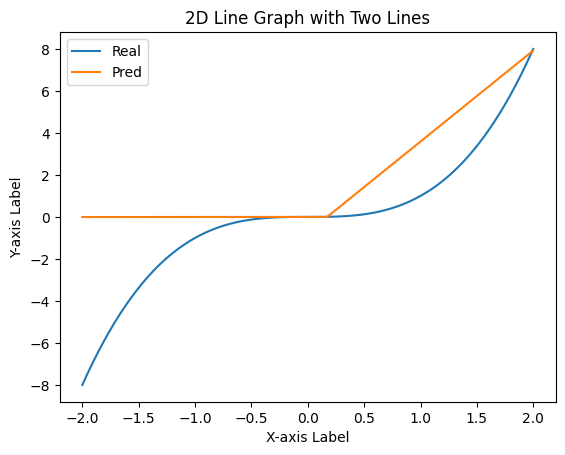

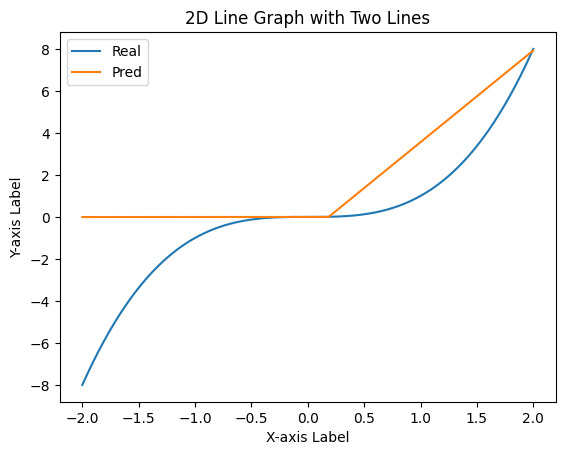

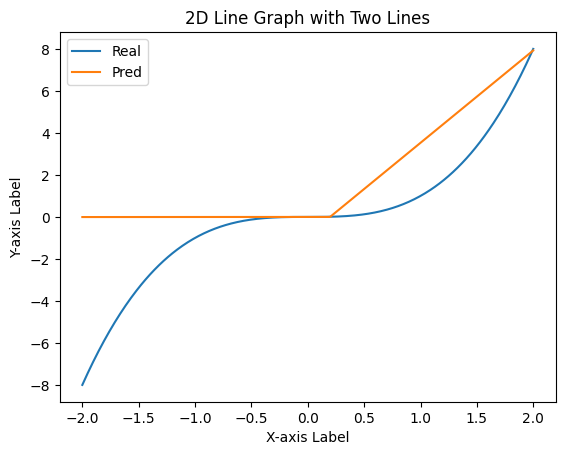

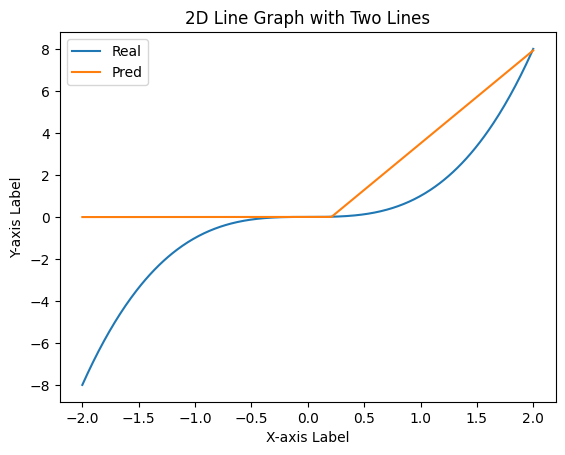

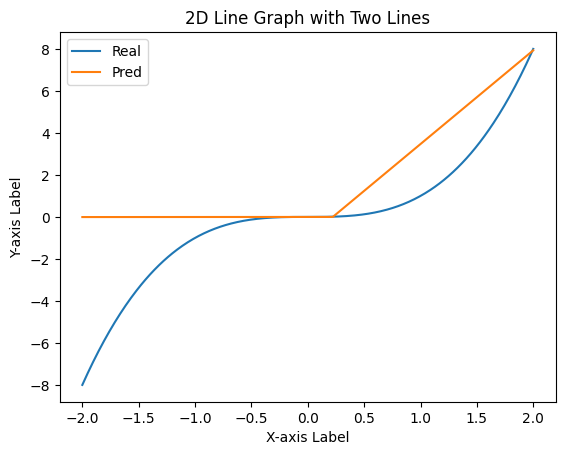

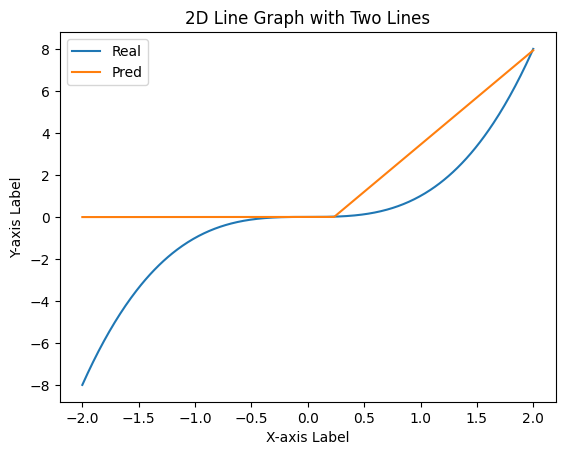

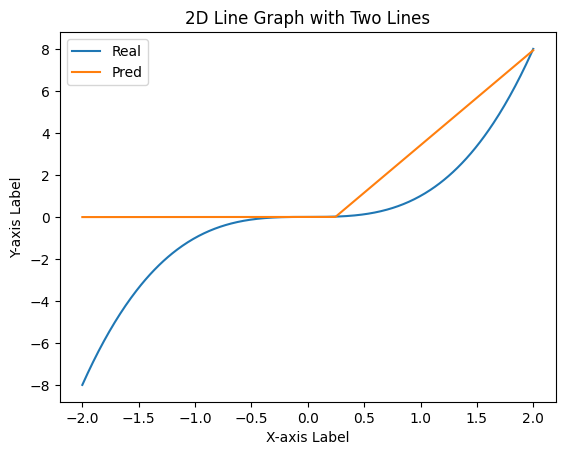

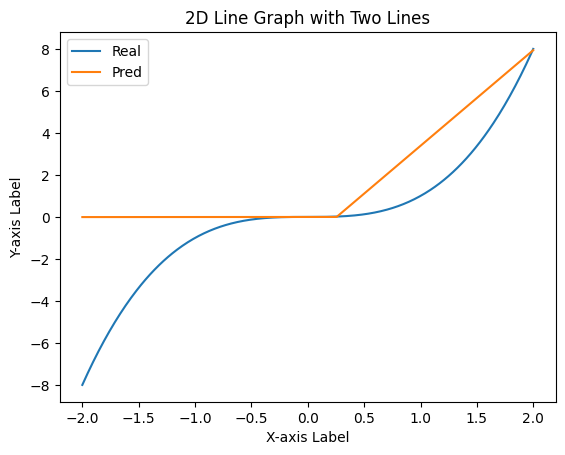

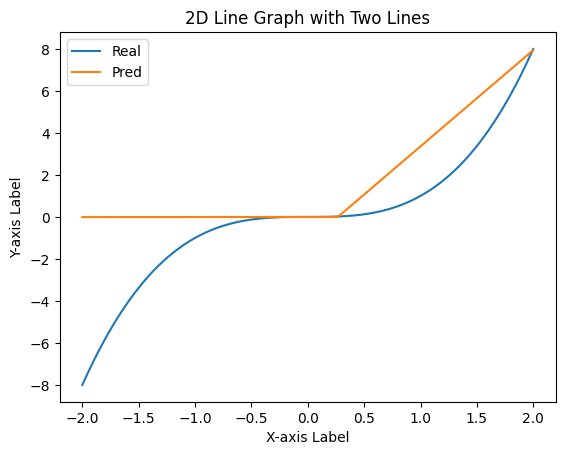

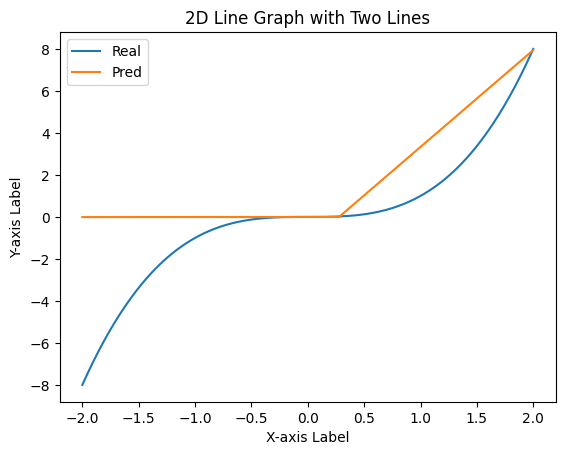

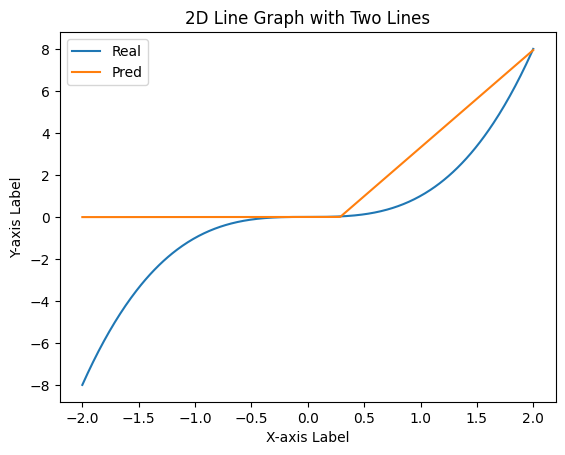

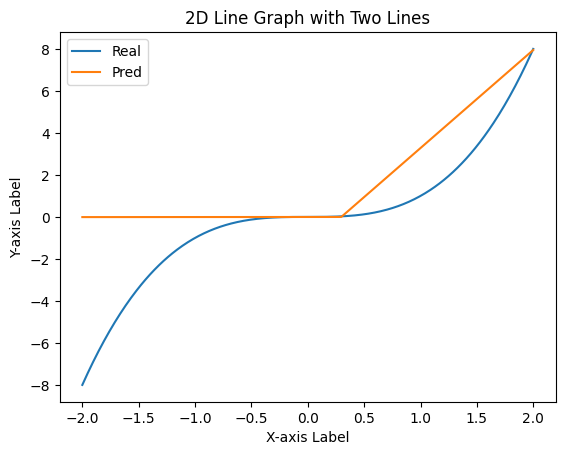

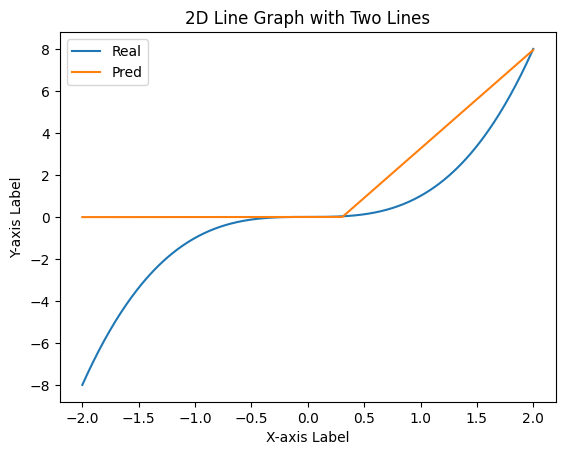

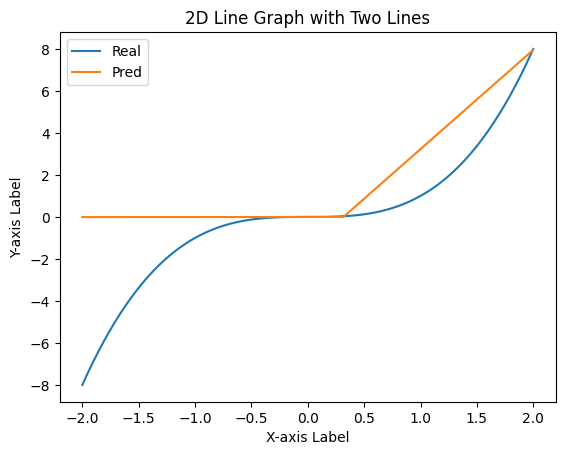

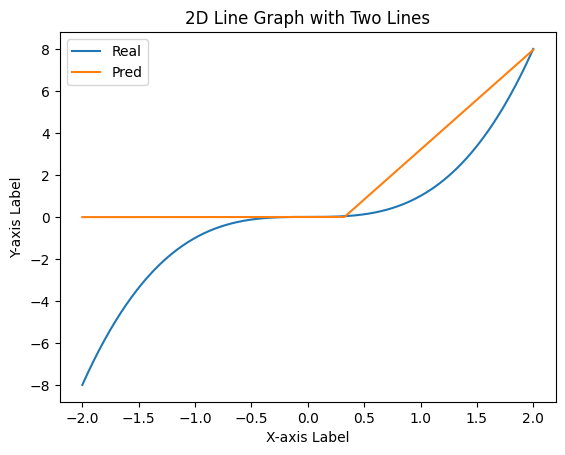

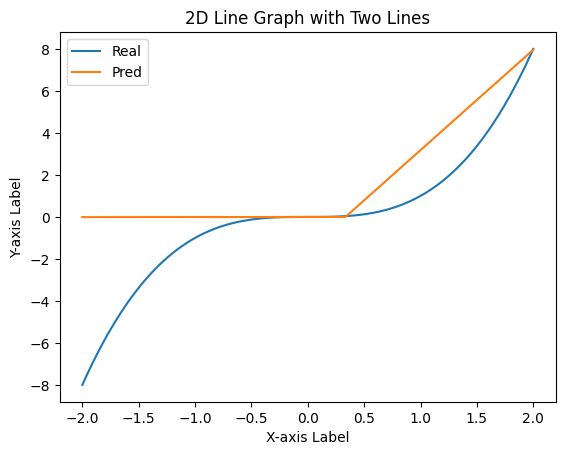

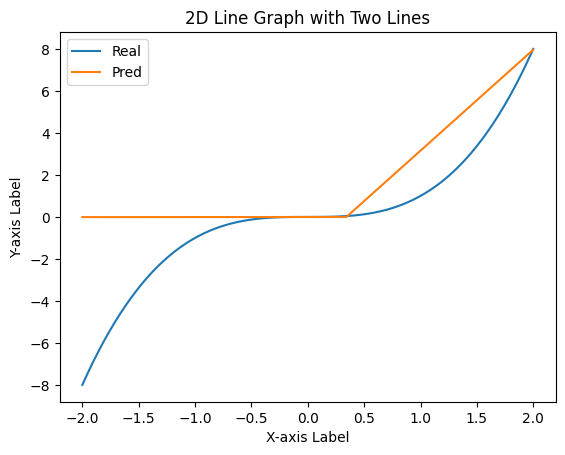

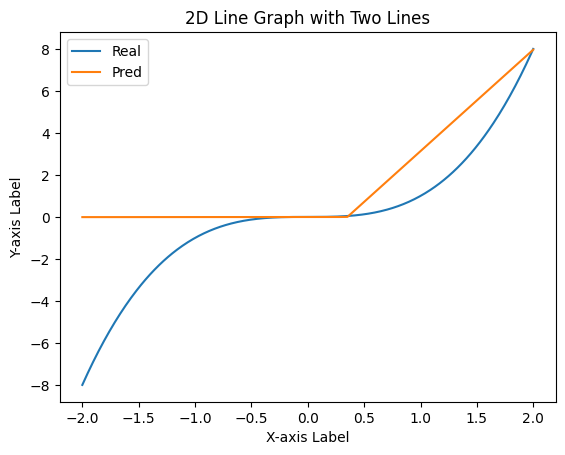

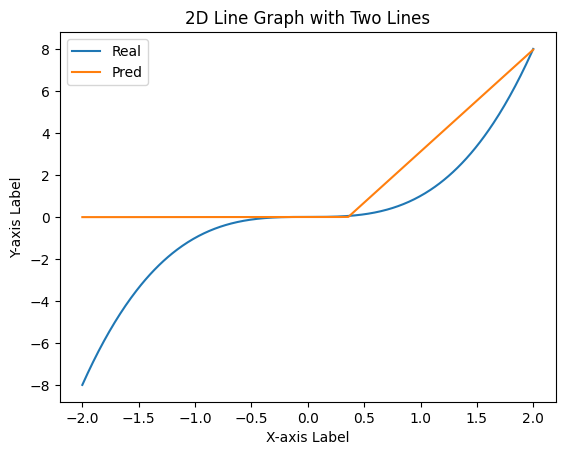

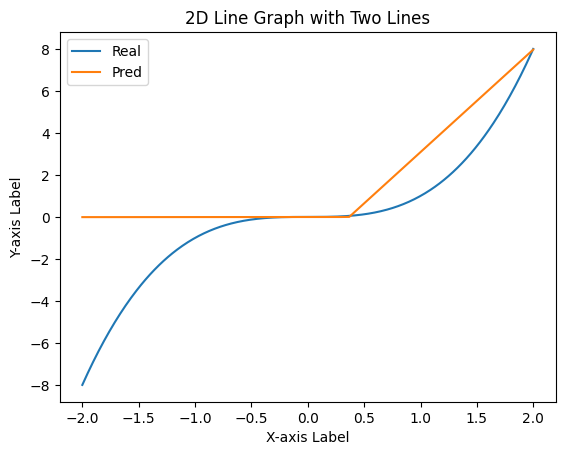

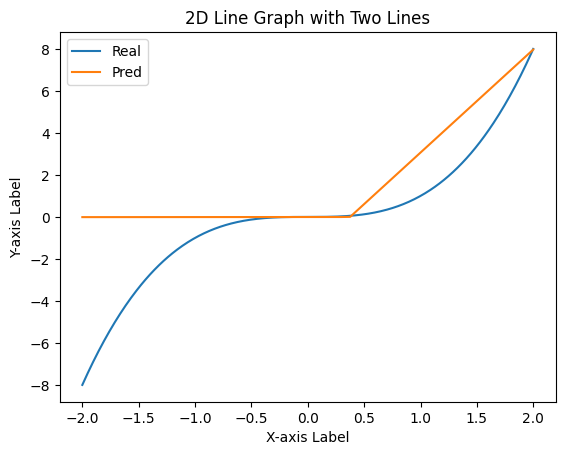

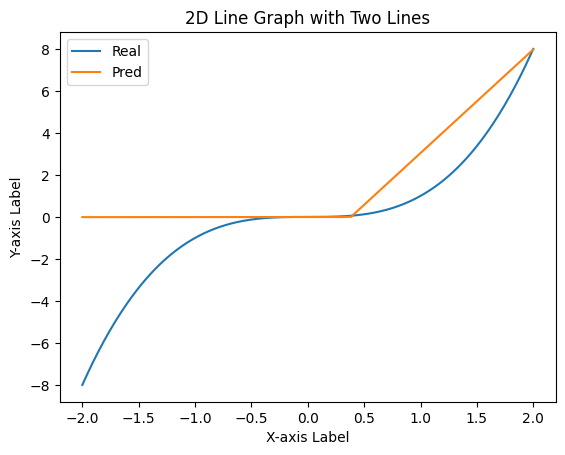

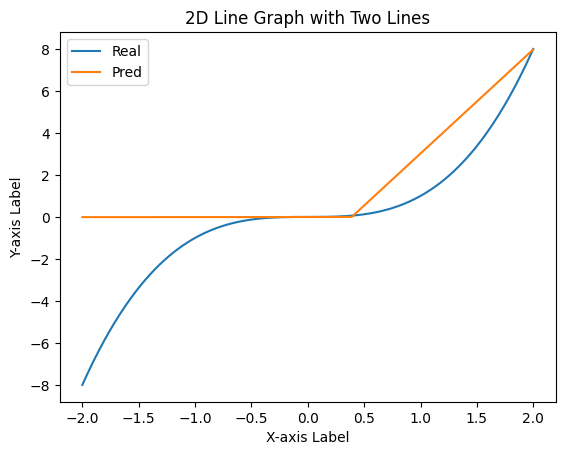

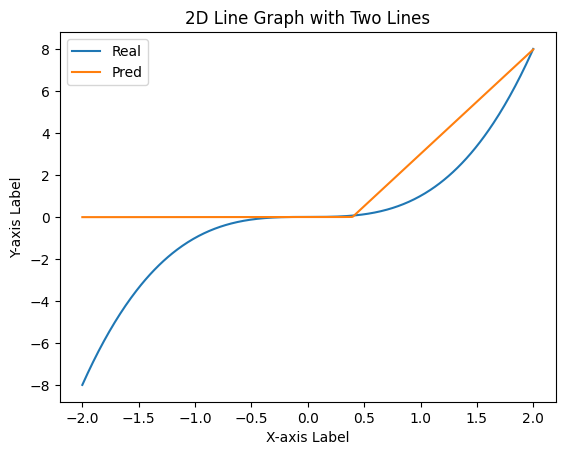

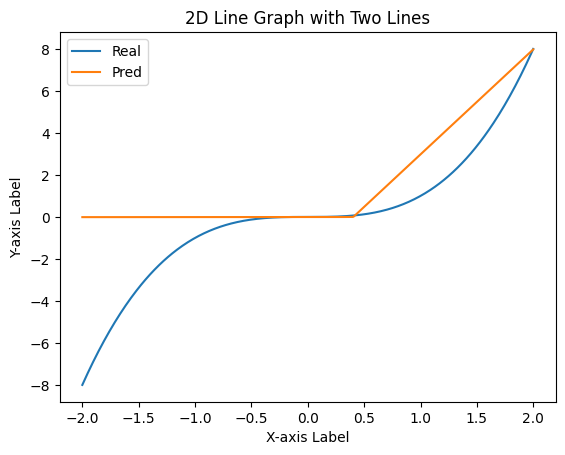

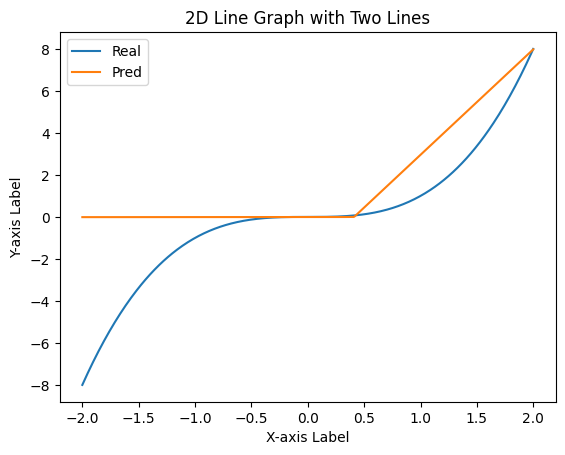

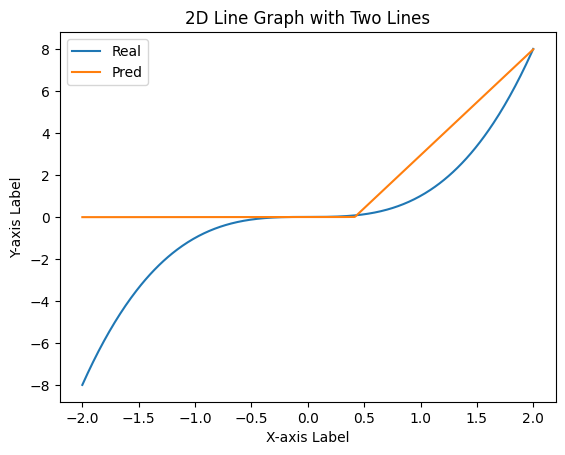

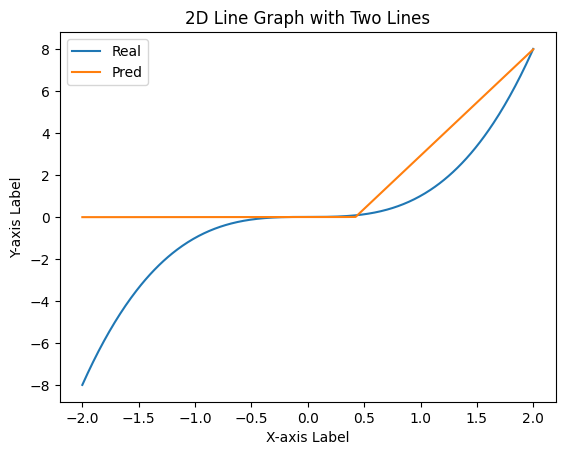

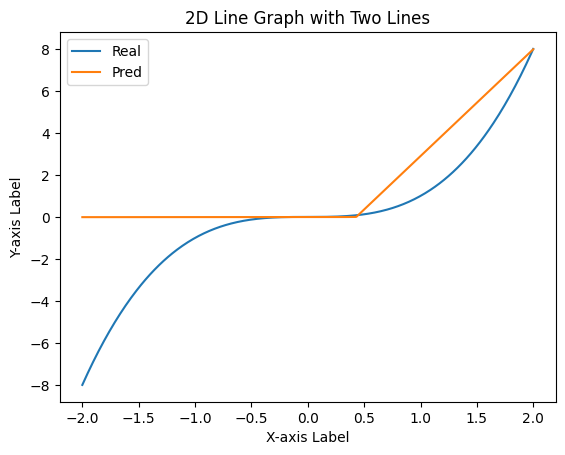

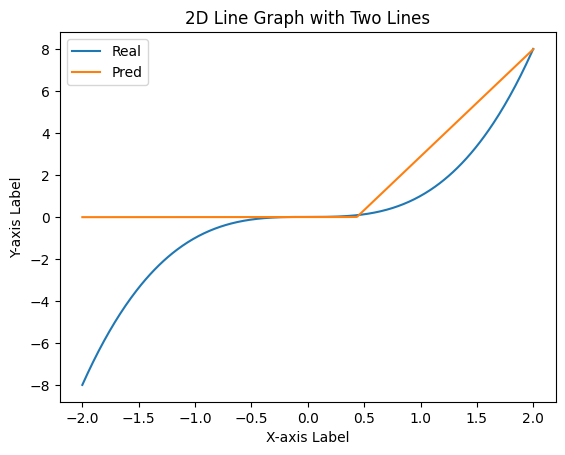

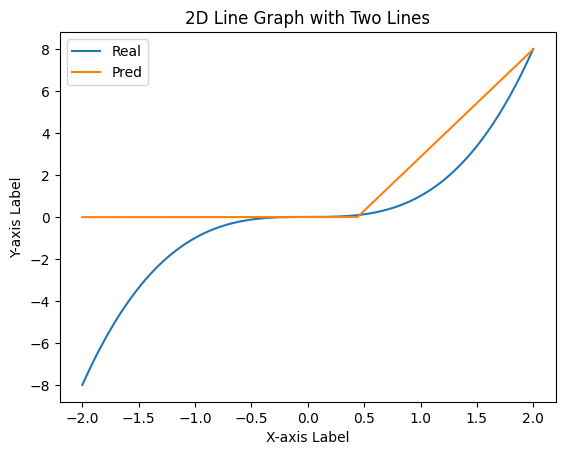

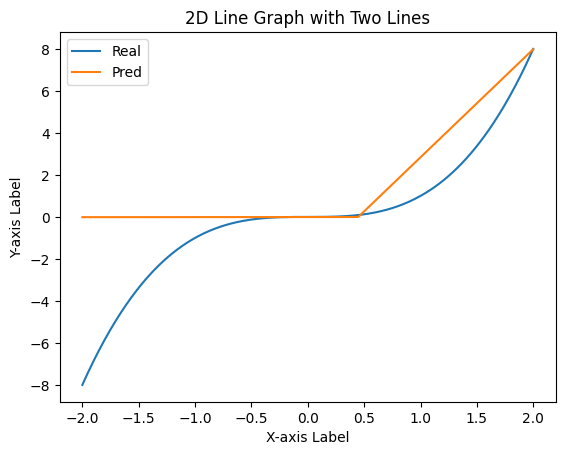

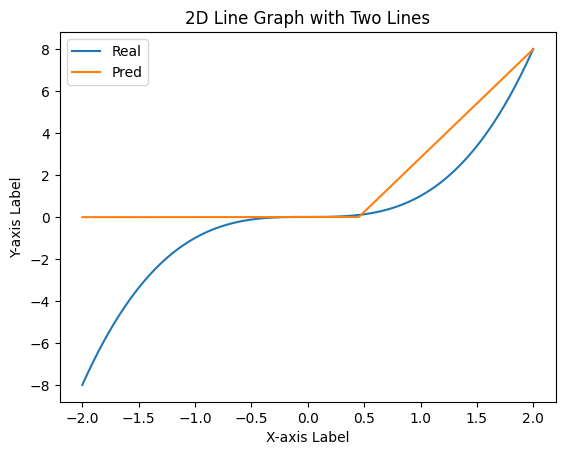

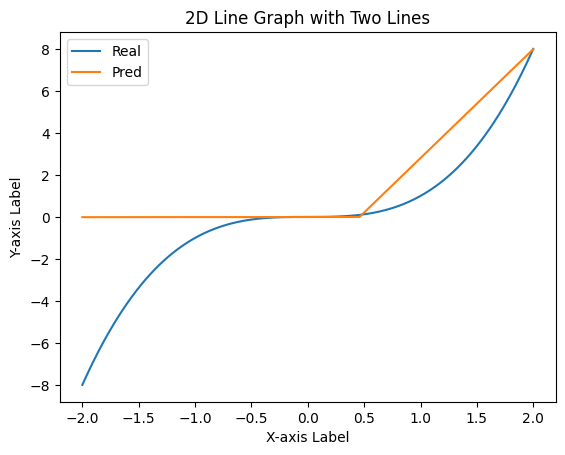

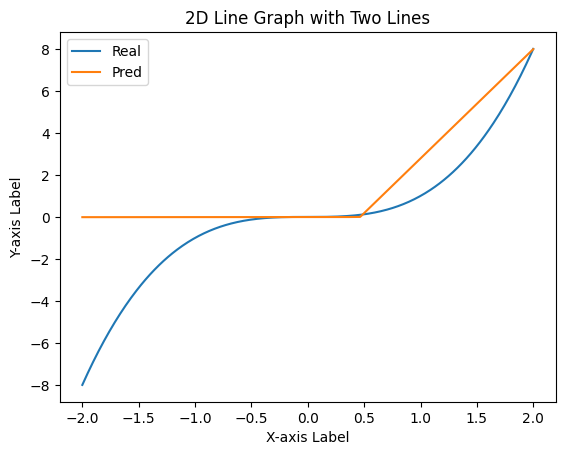

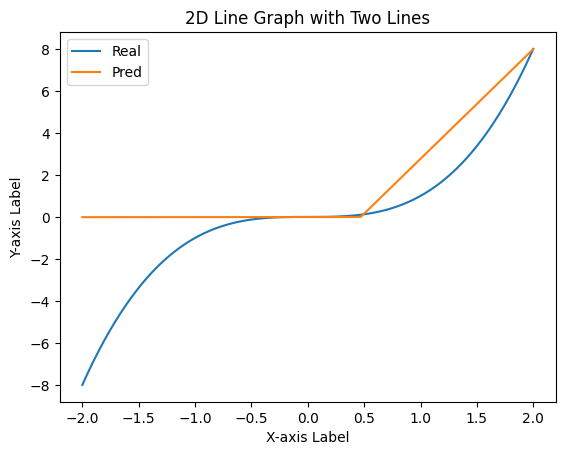

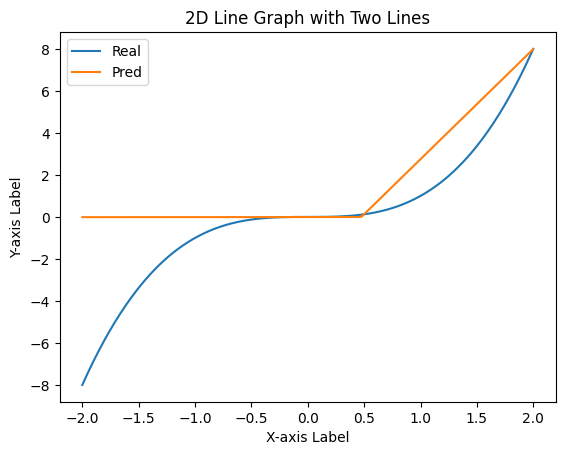

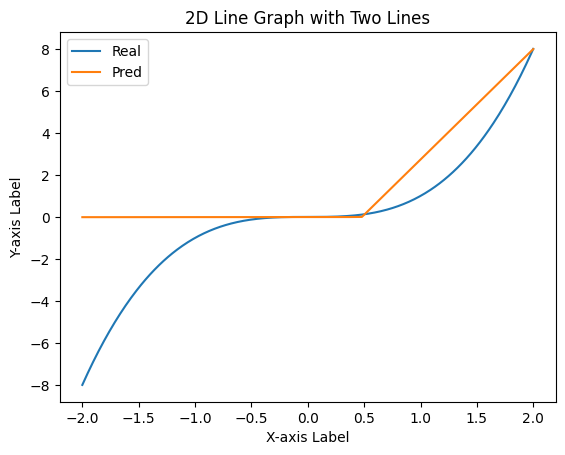

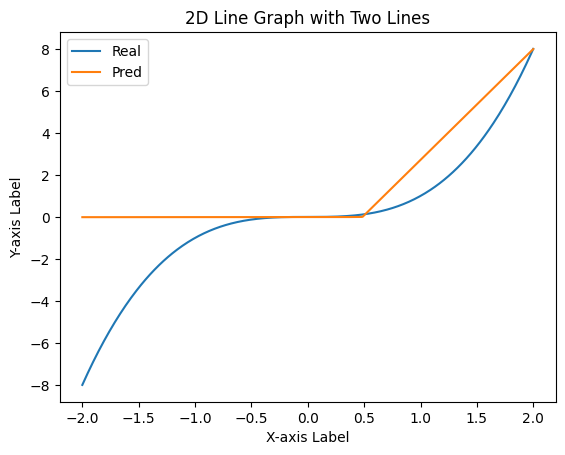

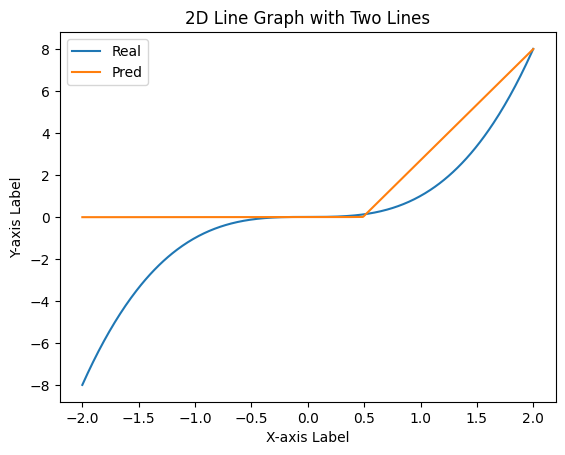

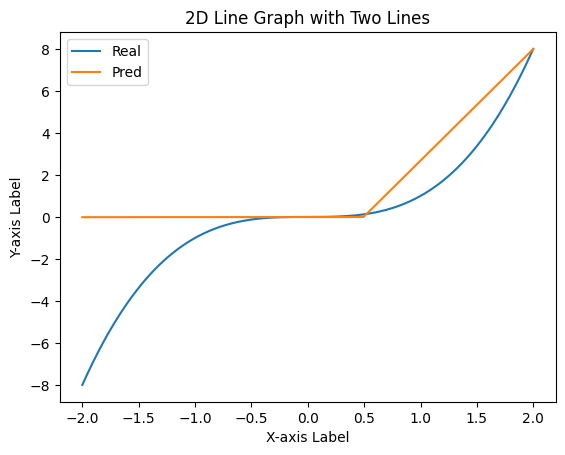

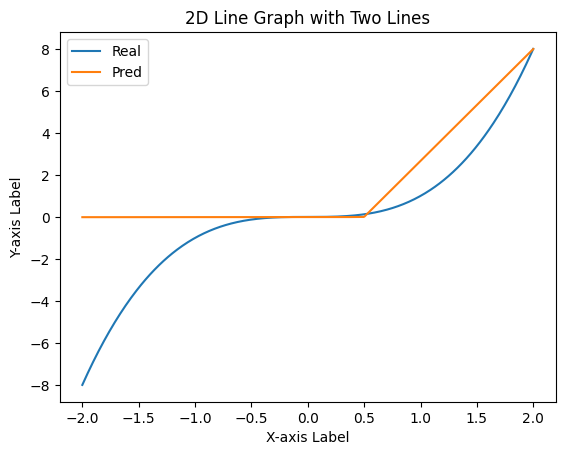

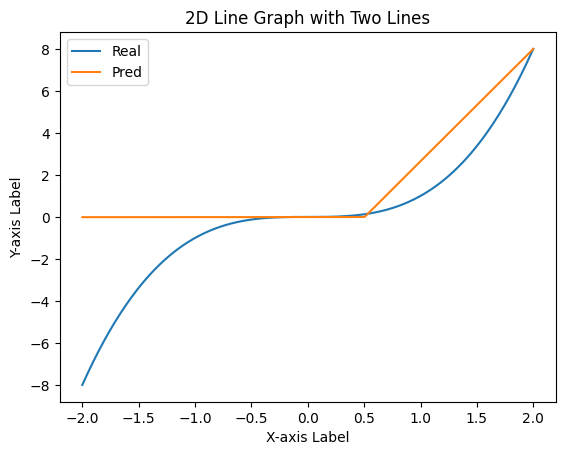

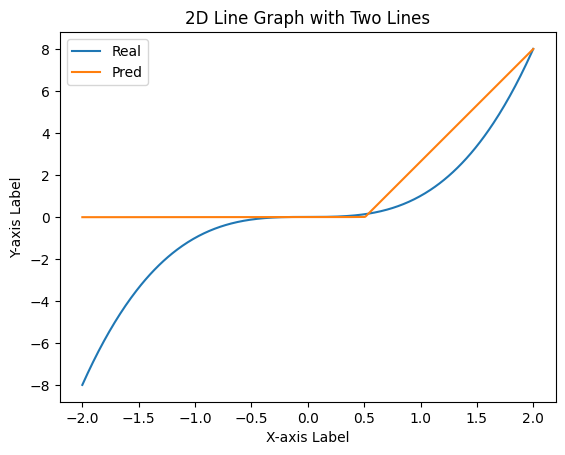

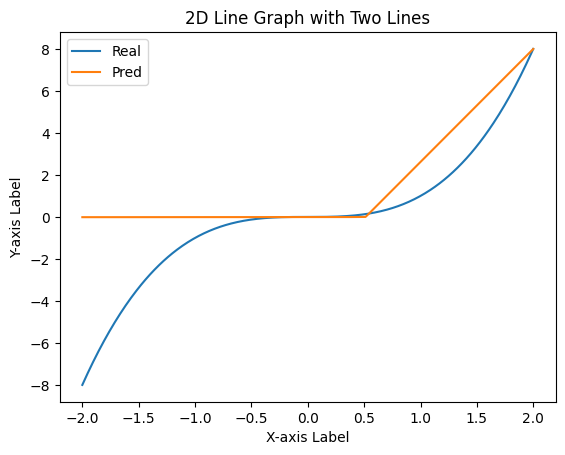

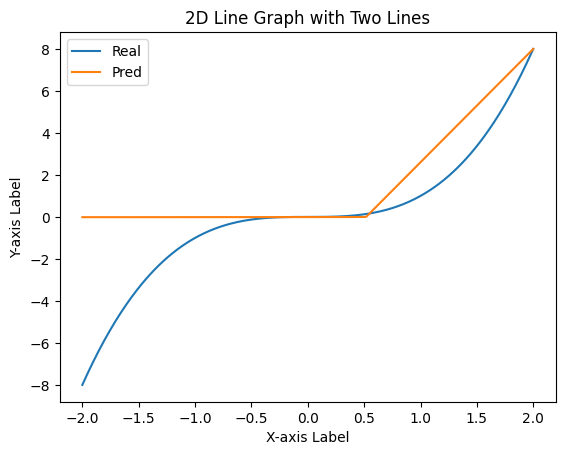

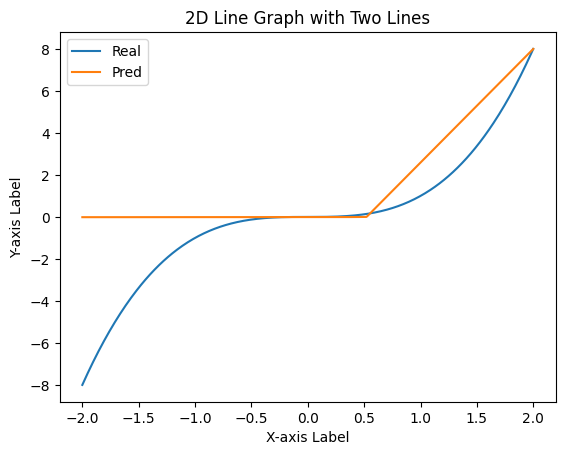

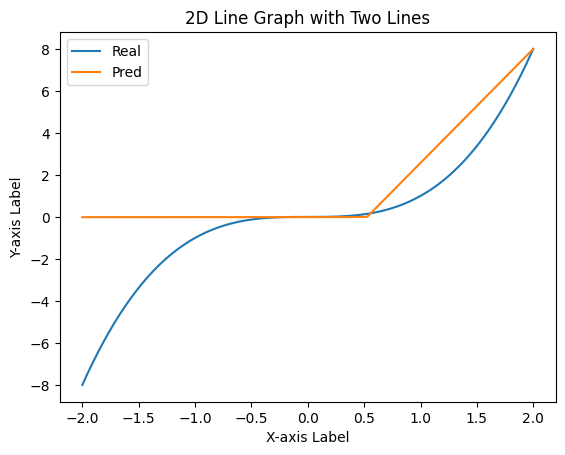

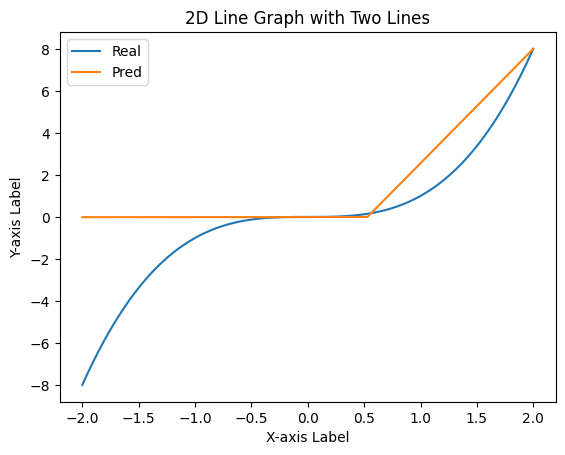

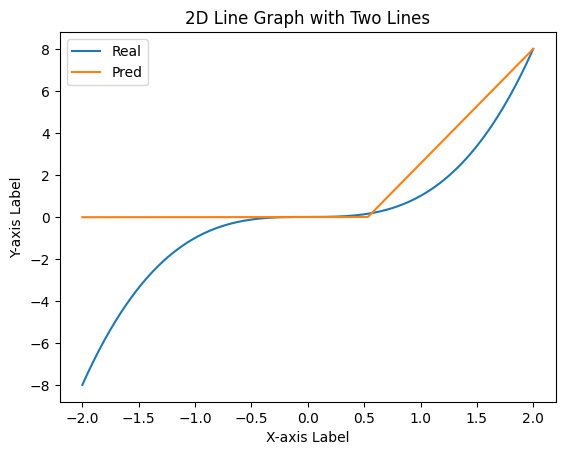

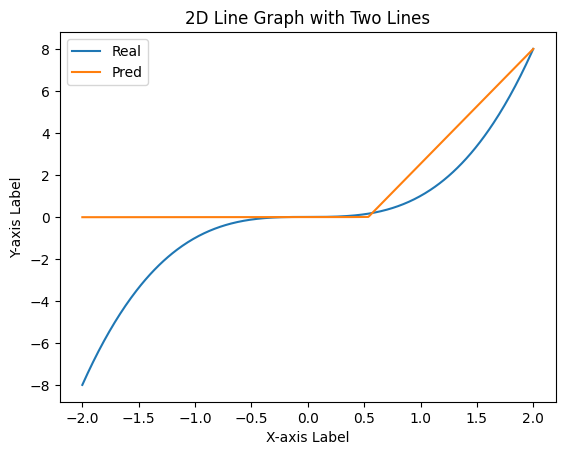

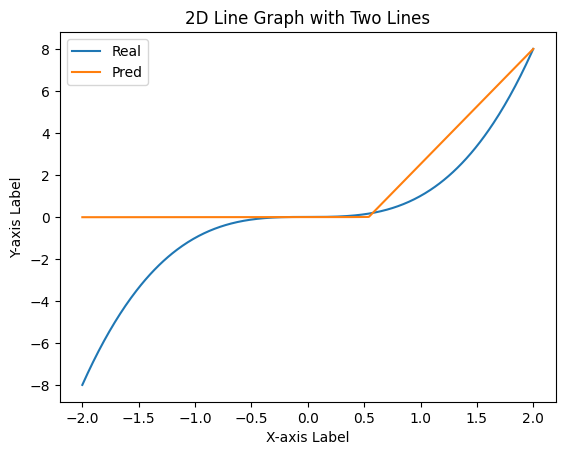

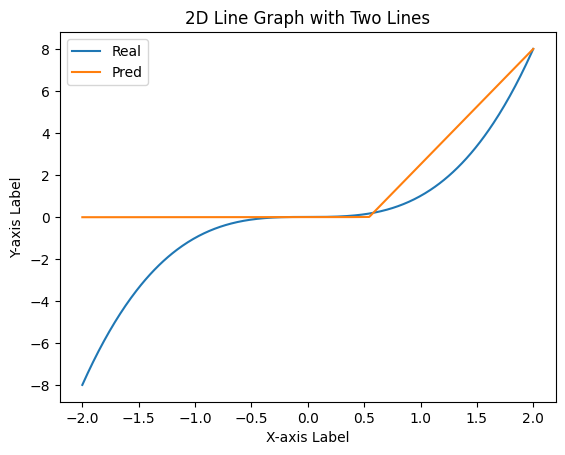

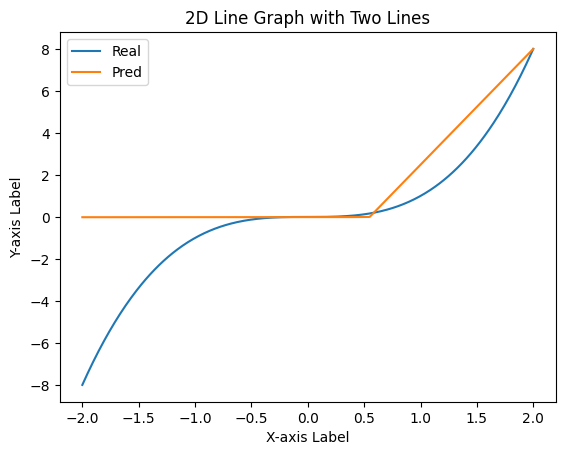

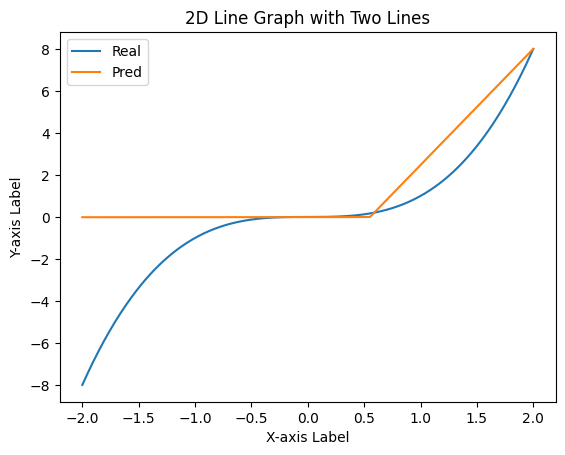

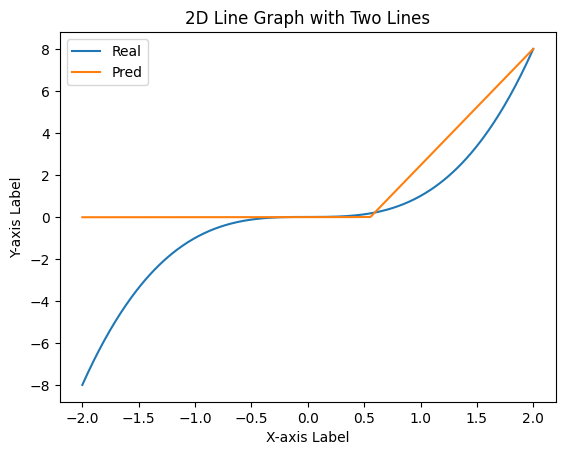

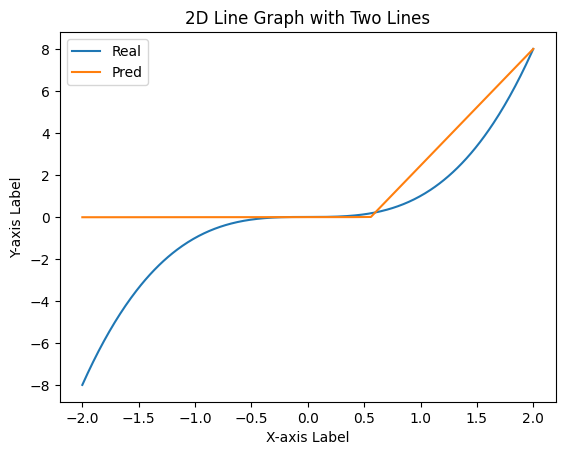

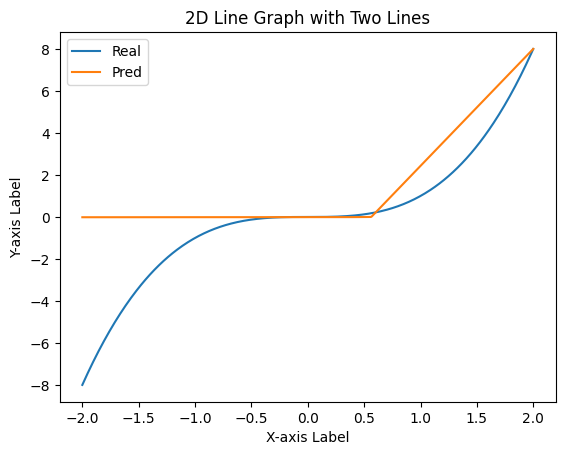

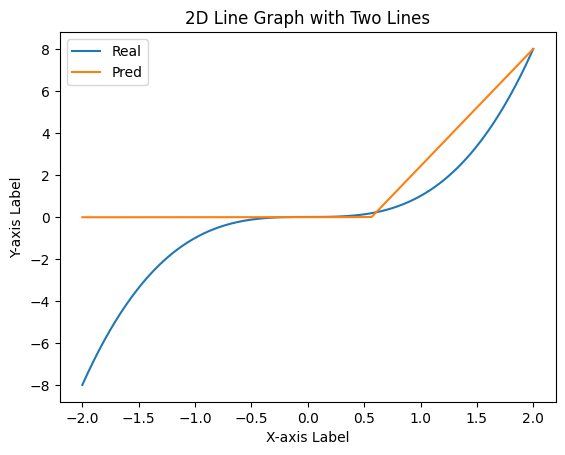

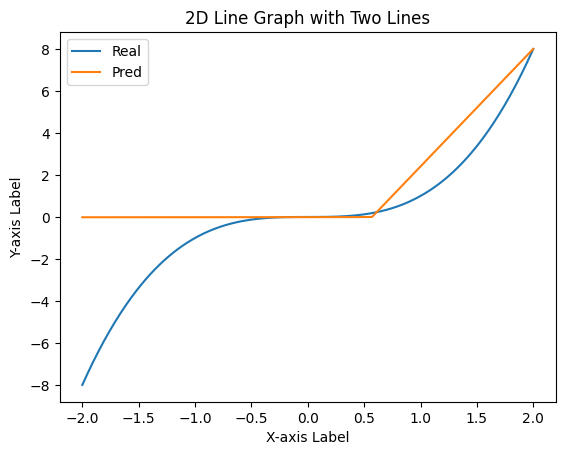

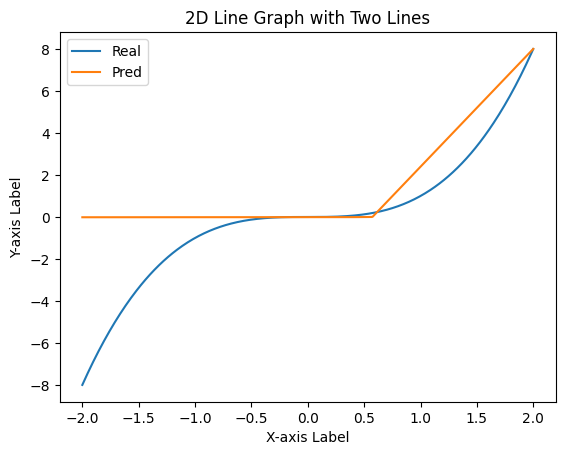

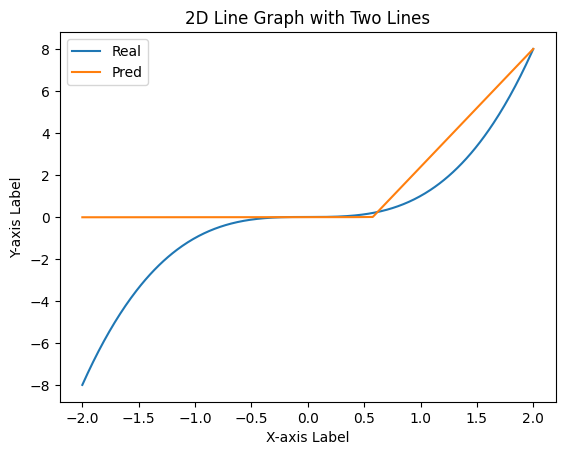

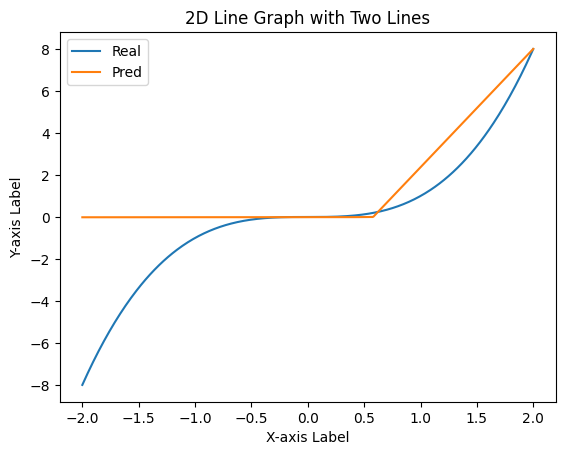

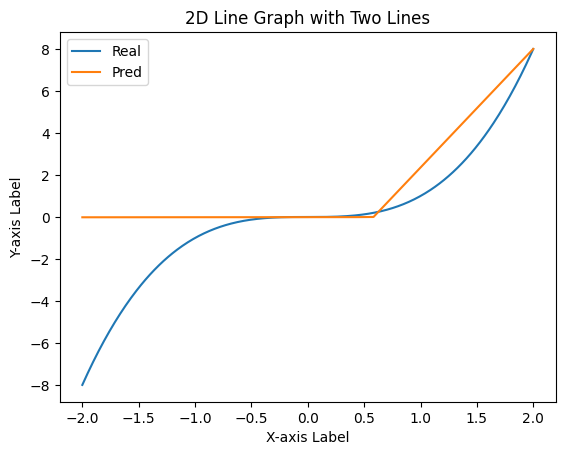

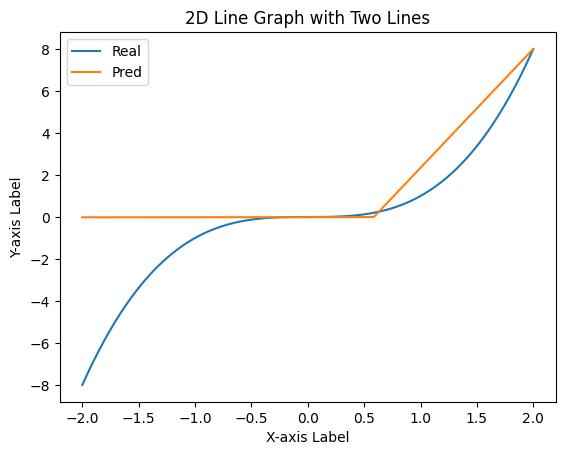

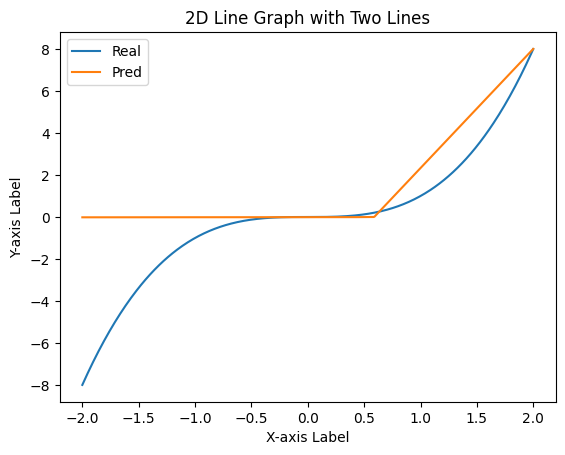

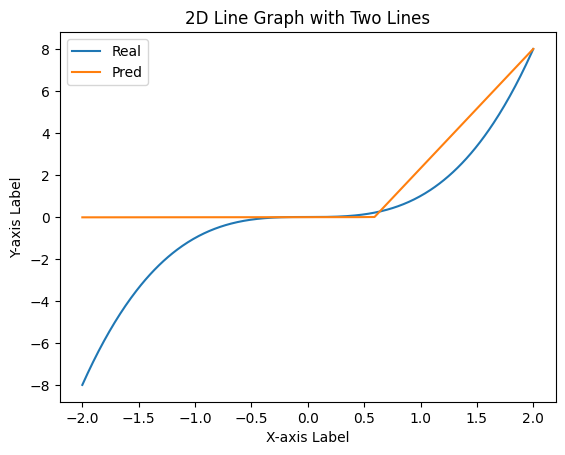

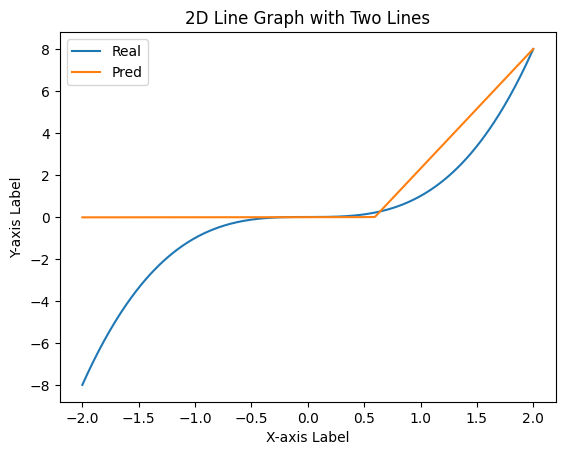

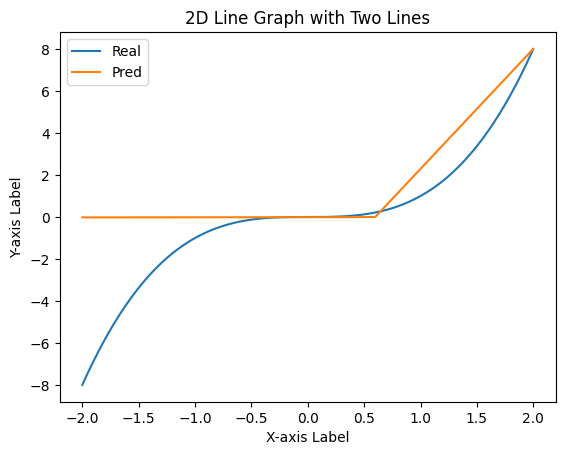

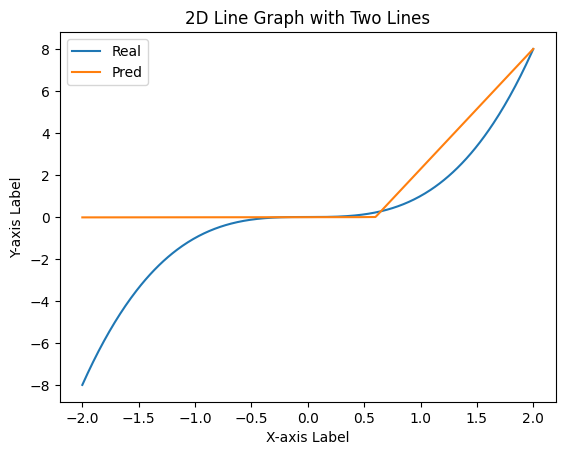

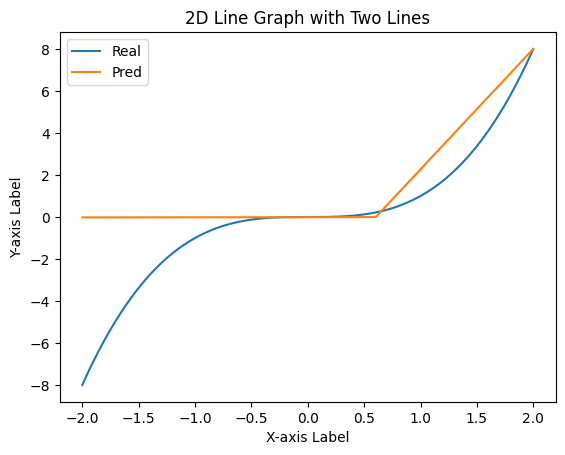

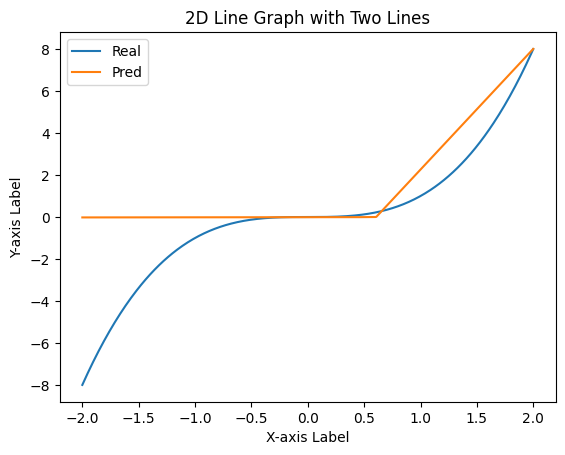

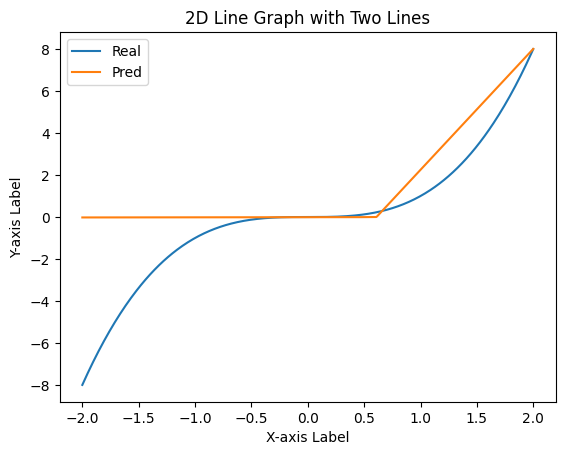

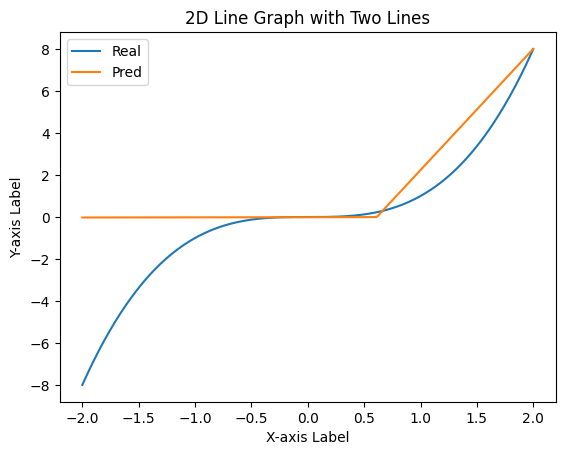

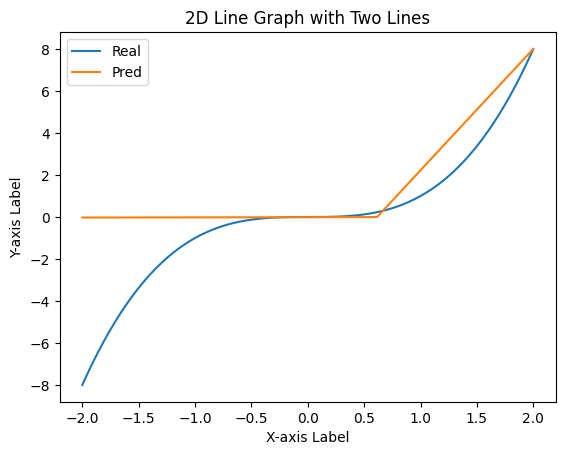

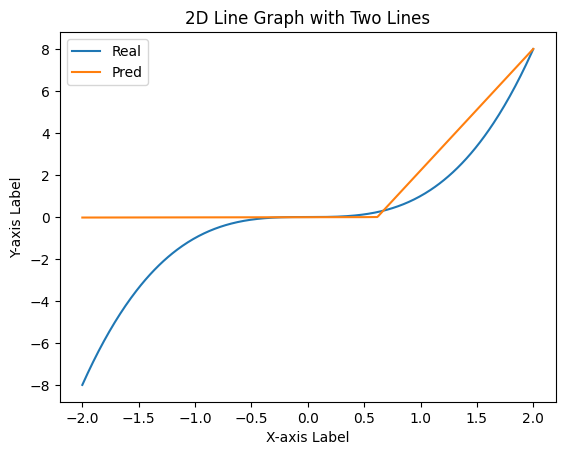

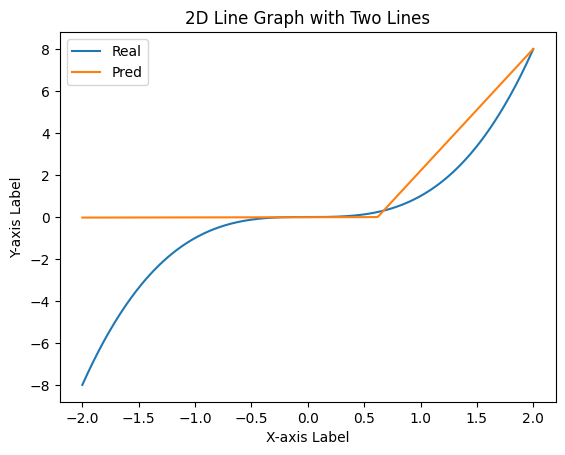

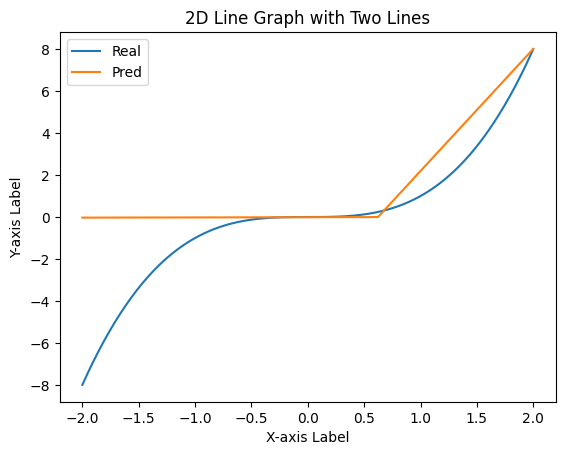

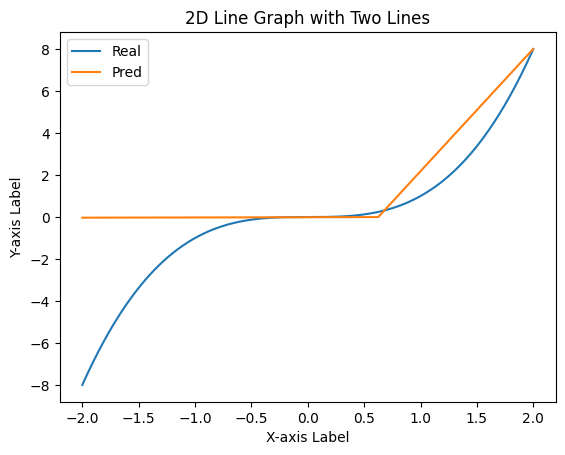

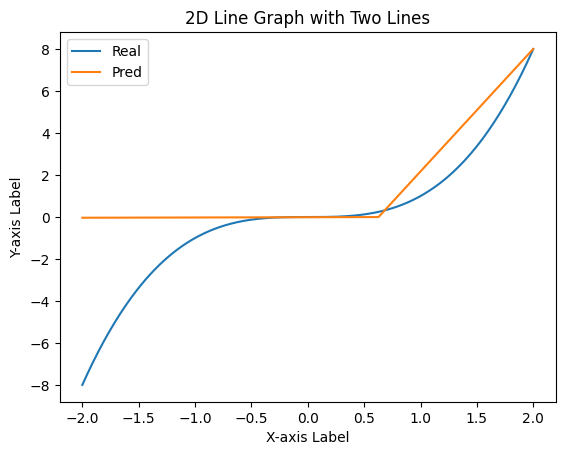

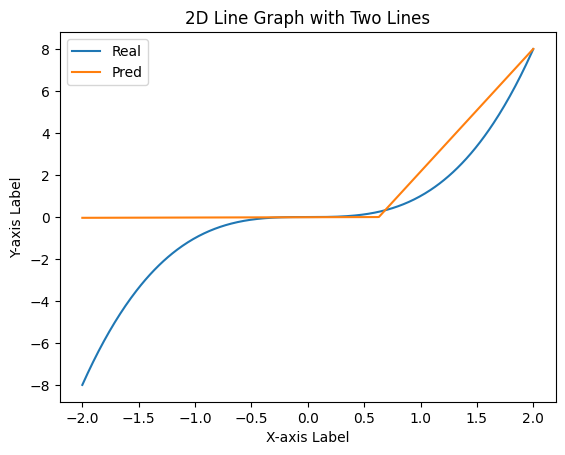

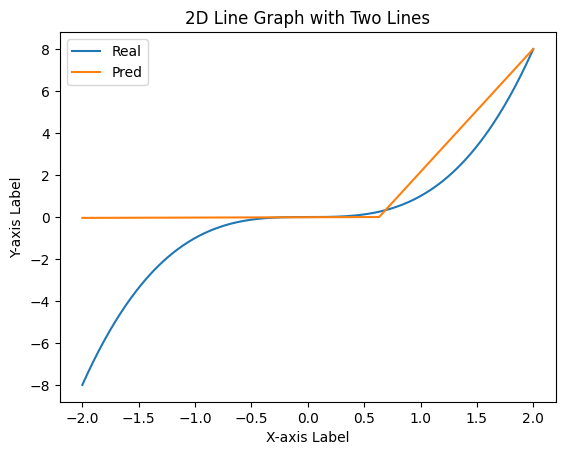

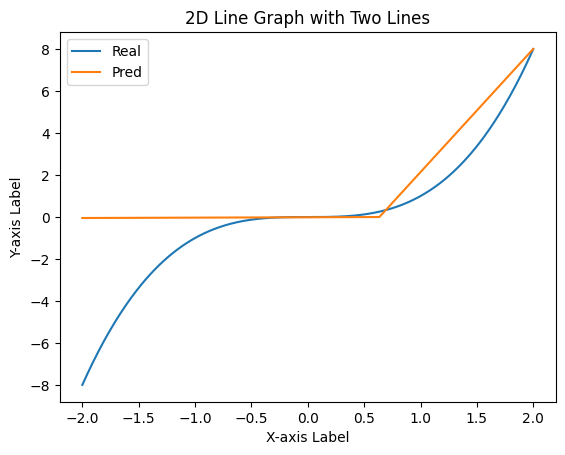

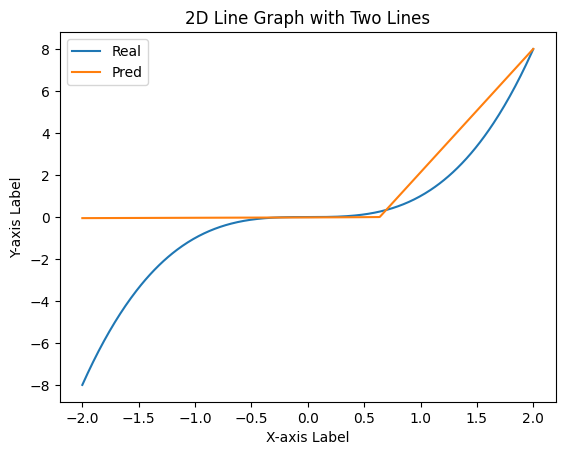

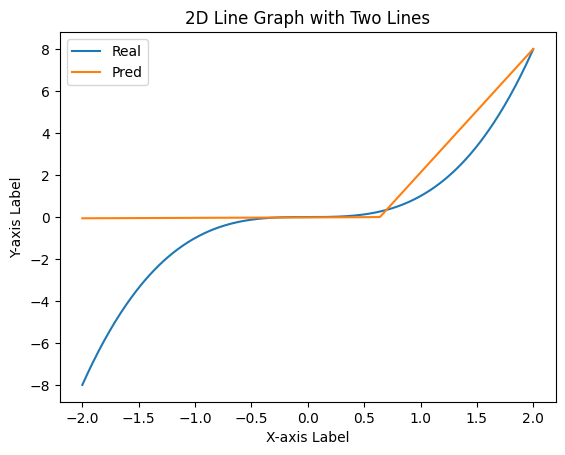

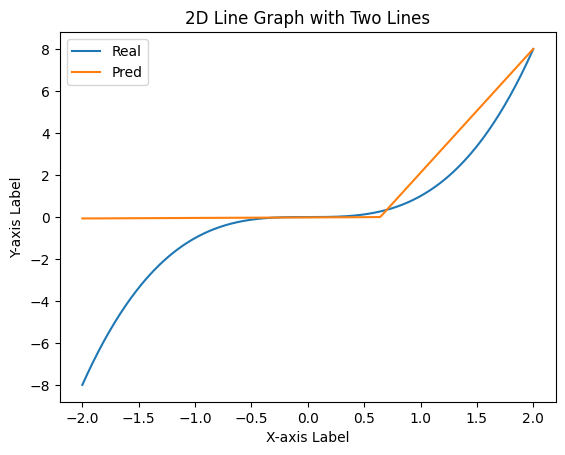

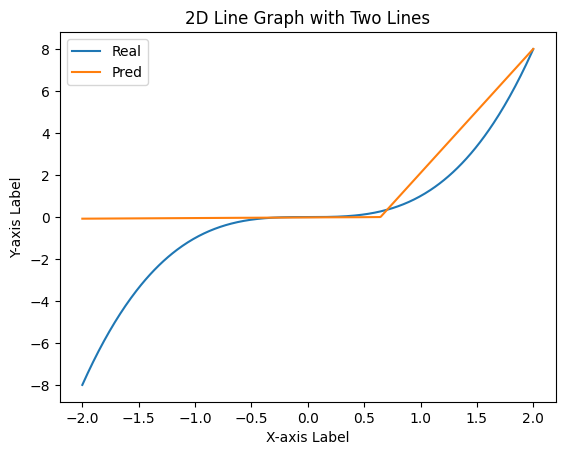

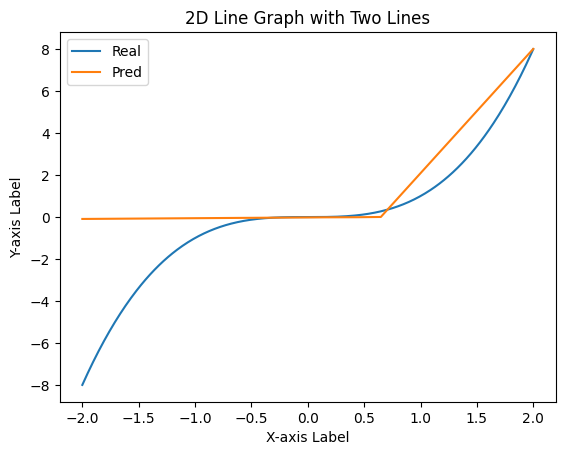

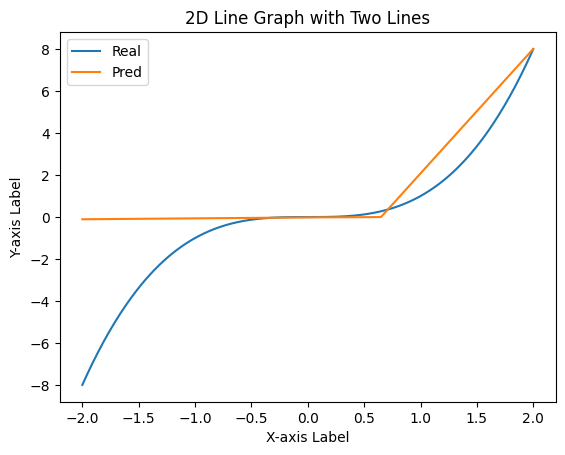

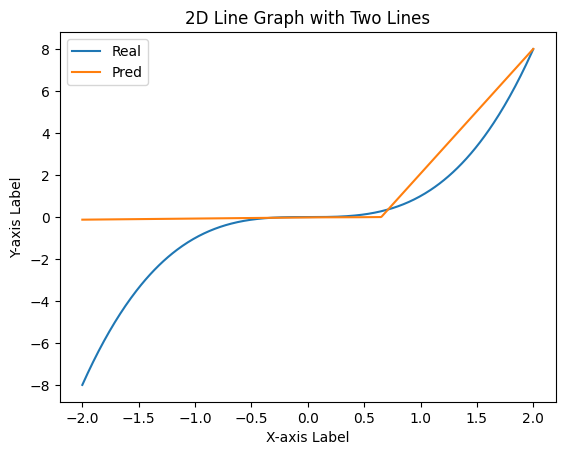

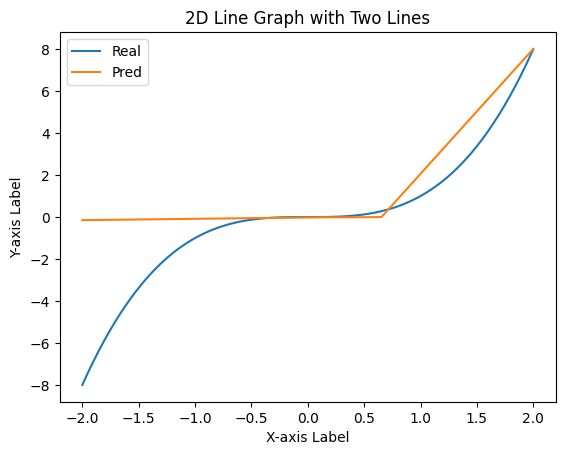

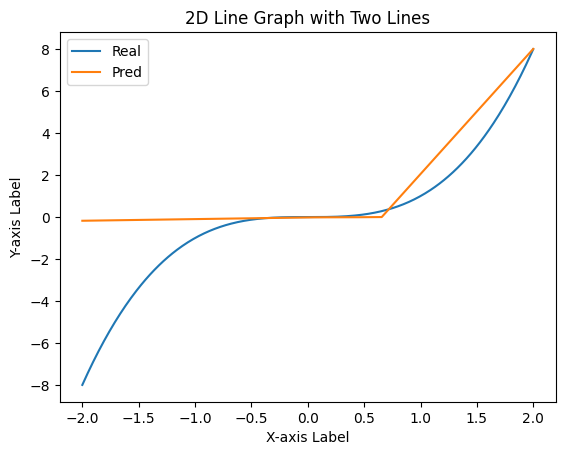

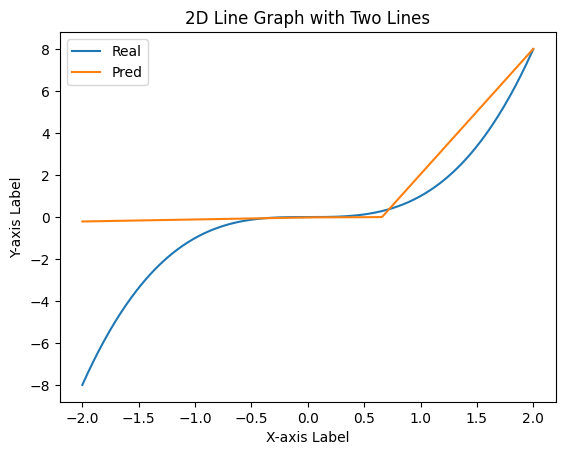

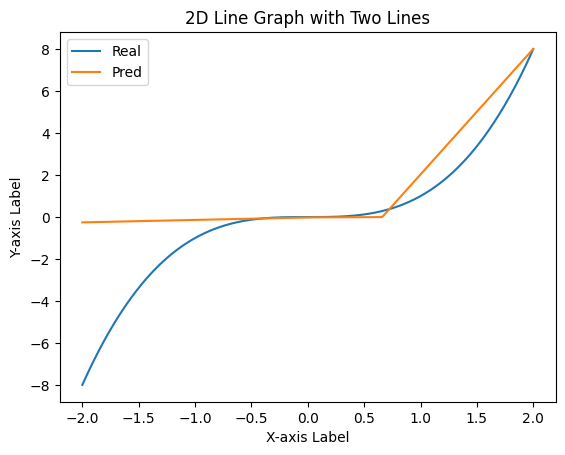

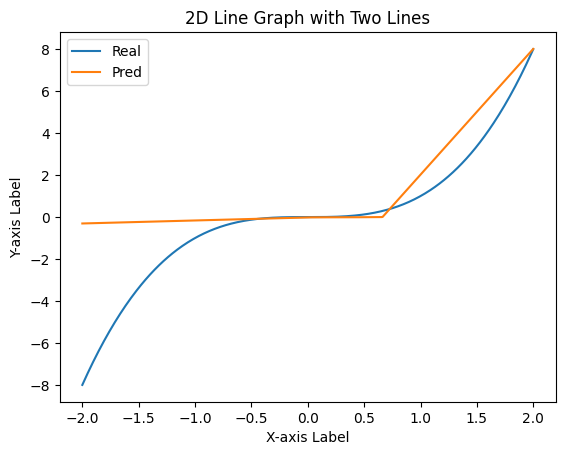

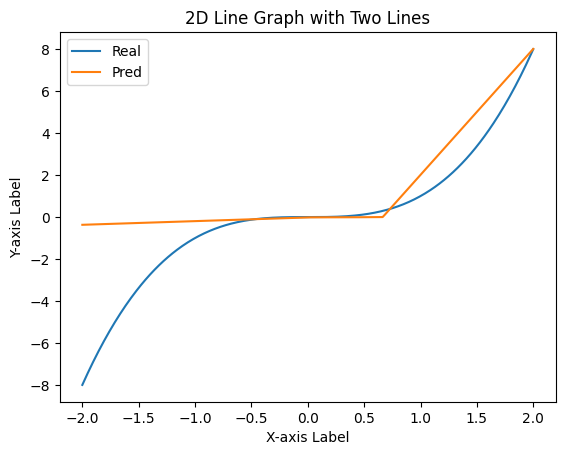

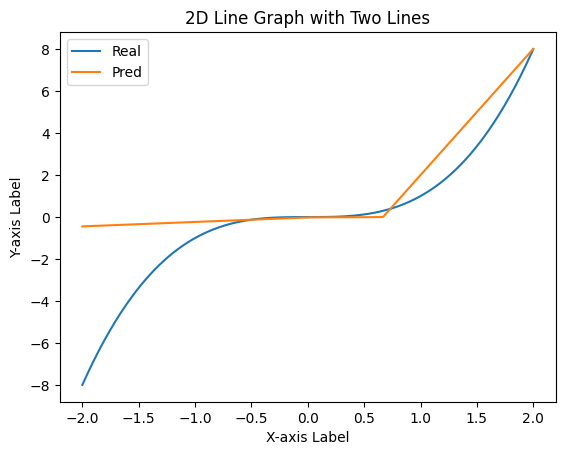

KeyboardInterrupt: ignored

<Figure size 640x480 with 0 Axes>

In [53]:
start_time = time.time()
initial_cost = cost(NN.predict(X_train), y_train)
loss = initial_cost

iterations = 0
a = 5e-4
g = .9
while(loss>1e-4 and iterations<200):
  if (iterations>1):
    g = .5
  loss = fit(a, g, method="online")
  predictions = NN.predict(X_train)
  print_graph(predictions)
  iterations += 1
finish_time = time.time()

In [ ]:
print(f"Time for {iterations} iterations: {finish_time-start_time}, change in loss={initial_cost - loss}")